In [1]:
# Import libraries
import numpy as np
import cv2 as cv
import os
import time
import sympy as sp
from scipy.signal import butter, lfilter
from scipy import signal
from scipy.signal import find_peaks
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing
from matplotlib.image import imread
import matplotlib.pyplot as plt 

In [16]:
# Setting plotting parameters
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
#plt.rcParams["font.family"] = "Helvetica"
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18) 

In [3]:
df_dir = r'E:\1. UTSA Ph.D\2. NASA ODPO\1. Tests\FST_402\Results'
os.chdir(df_dir)

In [6]:
file = r'FST 402 3D Curve Fits.xlsx'

df = pd.read_excel(file)
df = df.drop('Unnamed: 0', axis = 1)

In [7]:
df.head()

,Image #,Time,C_Mx,C_My,C_Mz,Vx,Vy,Vz,Ax,Ay,Az,Theta,Psi,Theta_dot,Psi_dot,Omega_dot_dot,Psi_dot_dot,Theta_dot_dot
0,1324,0.00,-0.001146,-0.162585,3.036005,NaN,NaN,NaN,NaN,NaN,NaN,3.476880,-9.483414,NaN,NaN,0,NaN,NaN
1,1325,0.05,0.186661,-0.134710,3.047954,3.758276,0.557718,0.238968,86.221547,8.14536,0.0,3.482344,-9.504613,109.617379,-424.490573,0,-19980.83235,12743.870904
2,1326,0.10,0.374682,-0.106814,3.059902,3.762587,0.558125,0.238968,86.221547,8.14536,0.0,3.487841,-9.525863,110.254573,-425.489615,0,-19980.83235,12743.870904
3,1327,0.15,0.562919,-0.078897,3.071850,3.766898,0.558532,0.238968,86.221547,8.14536,0.0,3.493370,-9.547162,110.891766,-426.488656,0,-19980.83235,12743.870904
4,1328,0.20,0.751372,-0.050960,3.083799,3.771209,0.558939,0.238968,86.221547,8.14536,0.0,3.498930,-9.568512,111.528960,-427.487698,0,-19980.83235,12743.870904


In [8]:
OD = 0.504 # Outter Diameter, in
L = 1.509 # Length, in
ID = 0 # Inner Diameter, in
m = 13.28 # Mass, g
P0 = 91.7 # Stagnation pressure, psia

In [9]:
OD = 25.4*OD/1000 # Outter Diameter, m
L = 25.4*L/1000 # Length, m
ID = 25.4*ID/1000 # Inner Diameter, m
m = m/100 # Mass, g
P0 = 6894.76*P0 # Stagnation pressure, pa

A = np.pi*(OD**2 - ID**2)/4 # Reference area, m^2
q_inf = P0 # Stagnation/dynammic pressure of test, Pa
g = 9.81 # Acceleration due to gravity, m/s^2
U_inf = 886.33 # Freestream velocity, m/s
I_yy = (1/12)*m*( 3*(OD**2 + ID**2)  + L**2) # Moment of inertia about the pitching axis/center of mass, kgm^2

In [12]:
df_coeff = df.copy()

In [13]:
df_coeff.head()

,Image #,Time,C_Mx,C_My,C_Mz,Vx,Vy,Vz,Ax,Ay,Az,Theta,Psi,Theta_dot,Psi_dot,Omega_dot_dot,Psi_dot_dot,Theta_dot_dot
0,1324,0.00,-0.001146,-0.162585,3.036005,NaN,NaN,NaN,NaN,NaN,NaN,3.476880,-9.483414,NaN,NaN,0,NaN,NaN
1,1325,0.05,0.186661,-0.134710,3.047954,3.758276,0.557718,0.238968,86.221547,8.14536,0.0,3.482344,-9.504613,109.617379,-424.490573,0,-19980.83235,12743.870904
2,1326,0.10,0.374682,-0.106814,3.059902,3.762587,0.558125,0.238968,86.221547,8.14536,0.0,3.487841,-9.525863,110.254573,-425.489615,0,-19980.83235,12743.870904
3,1327,0.15,0.562919,-0.078897,3.071850,3.766898,0.558532,0.238968,86.221547,8.14536,0.0,3.493370,-9.547162,110.891766,-426.488656,0,-19980.83235,12743.870904
4,1328,0.20,0.751372,-0.050960,3.083799,3.771209,0.558939,0.238968,86.221547,8.14536,0.0,3.498930,-9.568512,111.528960,-427.487698,0,-19980.83235,12743.870904


In [14]:
df_coeff['C_D'] = m*df.Ax/q_inf/A
df_coeff['C_L'] = -m*(df.Ay-g)/q_inf/A
df_coeff['C_z'] = m*df.Az/q_inf/A

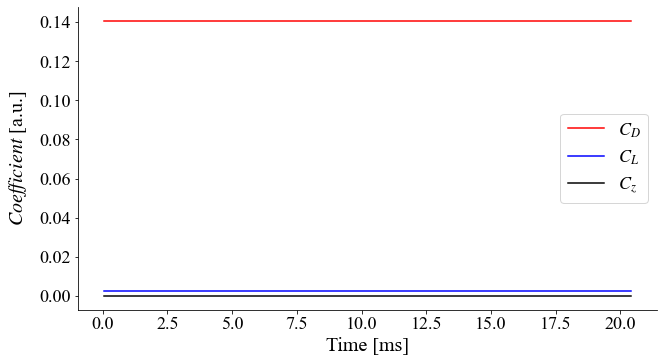

In [20]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
fig.tight_layout(pad=5.0)

plt.plot(df_coeff.Time, df_coeff.C_D, 'r', label = r'$C_D$')
plt.plot(df_coeff.Time, df_coeff.C_L, 'b', label = r'$C_L$')
plt.plot(df_coeff.Time, df_coeff.C_z, 'k', label = r'$C_z$')


plt.xlabel('Time [ms]', fontsize = 20)
plt.ylabel(r'$Coefficient$ [a.u.]', rotation = 90, fontsize = 20, labelpad=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
#plt.tick_params(axis = "y", which = "both", left = False, right = False)

plt.legend(fontsize = 18)

plt.show()

In [31]:
# Creating Matrix with data output
fst_num = 402
dataout = pd.DataFrame(np.zeros((1,1)), columns = ['FST Number'])
dataout.iloc[0,0] = fst_num 
dataout['C_D'] = df_coeff.C_D.mean() 
dataout['C_L'] = df_coeff.C_L.mean() 
dataout['C_z'] = df_coeff.C_z.mean() 

# track_log = pd.read_excel('Results.xlsx')
# track_log.drop(track_log.columns[0],axis = 1)
# track_log = track_log.append(dataout)
# track_log.to_excel('Results.xlsx',index = False)
# track_log

In [32]:
log_file = r'E:\1. UTSA Ph.D\2. NASA ODPO\2. Deliverables\NASA ODPO Aerocoefficients.xlsx'
track_log = pd.read_excel(log_file)
track_log.drop(track_log.columns[0],axis = 1)
track_log = track_log.append(dataout)
track_log.to_excel(log_file,index = False)
track_log

,FST Number,C_D,C_L,C_z
0,402.0,0.140704,0.002717,0.0
